In [1]:
import contractions
import emoji
import string 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from google_trans_new import google_translator
from lingua import Language, LanguageDetectorBuilder


nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
detector = LanguageDetectorBuilder.from_all_languages().build()

# Using generic python library is not very accurate and google translate API is too slow
def detect_non_english(text):
    description_detection_1 = detector.detect_language_of(text[0]) # Returns top 2 detected language

    if(description_detection_1 != None): # Return description detection_1 since only 1 language was detected
        return description_detection_1


    if(description_detection_1 == None): # Check title for cross reference on language if description language is unknown
        
        title_detection_1= detector.detect_language_of(text[1])

        if(title_detection_1 == None): # Both are None
            return "Unknown"
        
        elif(title_detection_1 != None):
            return title_detection_1

    return "Unknown"
    

In [3]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = stopwords.words('english')
    STOPWORDS.remove('not')
    STOPWORDS.remove('is')
    STOPWORDS.remove('but')
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    return ' '.join([word for word in reviews.split() if word not in STOPWORDS])

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

In [4]:

def clean_text(data):

    data['reviewDescription'] = data['reviewDescription'].apply(lower_case)
    data['reviewDescription'] = data['reviewDescription'].apply(change_contractions)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_emojis)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_punctuations)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_numbers)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_stopwords)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_extra_whitespace)
    data['reviewDescription'] = data['reviewDescription'].apply(lemmaSentence)
    
    return data

In [5]:
raw_dataset = pd.read_csv("raw_dataset/raw_dataset.csv", encoding='utf-8')
raw_dataset

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category
0,0,451524934,1,Boomer Pornography,39 people found this helpful,Orwell certainly takes an interesting approach...,True,humor_entertainment
1,1,451524934,1,THIS IS NOT A HARD COVER!!!,One person found this helpful,I was very excited to buy this book because my...,True,humor_entertainment
2,2,451524934,1,L E S S GOVERNMENT,One person found this helpful,I am trying to digest this horrible book. Its...,True,humor_entertainment
3,3,451524934,1,"Spoiler free. In summation, awful.",4 people found this helpful,The audiobook was well narrated. That’s about ...,True,humor_entertainment
4,4,451526341,1,"""Free"" book sold for $3.99",NaN,I purchased several e-books for use in plannin...,True,humor_entertainment
...,...,...,...,...,...,...,...,...
24324,24324,399587683,5,Lovely story!,NaN,"The characters are so relatable, and the story...",True,romance
24325,24325,399587683,5,Such an amazing book!!!,NaN,"I couldn’t put it down!!! I laughed, cried and...",True,romance
24326,24326,399587683,5,A fun summer read!,NaN,Perfect book for a beach week! Easy read and f...,True,romance
24327,24327,399587683,5,The Proposal,NaN,Such a good read! Definitely recommend. Thanks...,True,romance


In [6]:
raw_neg_dataset = pd.read_csv("raw_dataset/final_books_dataset_duplicates_removed_negative.csv", encoding='utf-8')

# We concat more negative ratings to have a balance os positive and negative ratings

data_df = pd.concat([raw_dataset, raw_neg_dataset]).drop_duplicates()
data_df

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category
0,0.0,451524934,1.0,Boomer Pornography,39 people found this helpful,Orwell certainly takes an interesting approach...,True,humor_entertainment
1,1.0,451524934,1.0,THIS IS NOT A HARD COVER!!!,One person found this helpful,I was very excited to buy this book because my...,True,humor_entertainment
2,2.0,451524934,1.0,L E S S GOVERNMENT,One person found this helpful,I am trying to digest this horrible book. Its...,True,humor_entertainment
3,3.0,451524934,1.0,"Spoiler free. In summation, awful.",4 people found this helpful,The audiobook was well narrated. That’s about ...,True,humor_entertainment
4,4.0,451526341,1.0,"""Free"" book sold for $3.99",NaN,I purchased several e-books for use in plannin...,True,humor_entertainment
...,...,...,...,...,...,...,...,...
6080,NaN,1250316774,1.0,Just awful.,NaN,"Stupid plot, insipid characters. Nothing about...",True,children
6081,NaN,1250316774,1.0,So much blablabla,NaN,Don’t like the type of book that don’t focus j...,True,children
6082,NaN,1250316774,1.0,"boring, predictable, 2 dimensional characters",NaN,I should have read more reviews before purchas...,False,children
6083,NaN,1250316774,1.0,Cringe,1.0,Characters taken right from a terrible rejecte...,True,children


In [7]:
data_df = data_df.reset_index()
data_df.drop(columns = ['index', 'Unnamed: 0'], inplace=True)
data_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category
0,451524934,1.0,Boomer Pornography,39 people found this helpful,Orwell certainly takes an interesting approach...,True,humor_entertainment
1,451524934,1.0,THIS IS NOT A HARD COVER!!!,One person found this helpful,I was very excited to buy this book because my...,True,humor_entertainment
2,451524934,1.0,L E S S GOVERNMENT,One person found this helpful,I am trying to digest this horrible book. Its...,True,humor_entertainment
3,451524934,1.0,"Spoiler free. In summation, awful.",4 people found this helpful,The audiobook was well narrated. That’s about ...,True,humor_entertainment
4,451526341,1.0,"""Free"" book sold for $3.99",NaN,I purchased several e-books for use in plannin...,True,humor_entertainment
...,...,...,...,...,...,...,...
30409,1250316774,1.0,Just awful.,NaN,"Stupid plot, insipid characters. Nothing about...",True,children
30410,1250316774,1.0,So much blablabla,NaN,Don’t like the type of book that don’t focus j...,True,children
30411,1250316774,1.0,"boring, predictable, 2 dimensional characters",NaN,I should have read more reviews before purchas...,False,children
30412,1250316774,1.0,Cringe,1.0,Characters taken right from a terrible rejecte...,True,children


In [8]:
data_df.to_csv('raw_dataset/raw_books_dataset.csv')

In [9]:
# Remove the non_english sentences 
data_df["reviewDescription"] = data_df["reviewDescription"].astype(str)
data_df['reviewTitle'] = data_df['reviewTitle'].astype(str)
data_df["languages"] = data_df[["reviewDescription", "reviewTitle"]].apply(detect_non_english, axis=1)

In [10]:
non_english_df = data_df[data_df["languages"]!=Language.ENGLISH]
non_english_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages
175,1984806734,1.0,Mal empastado,NaN,Está mal empastado vienen las primeras hojas m...,True,romance,Language.SPANISH
182,1984806734,1.0,Bitte bei Erhalt genau anschauen!!!,2 people found this helpful,Das Buch wurde verschenkt. Jetzt wollte diejen...,True,romance,Language.GERMAN
186,1984806734,1.0,Decepcionada,2 people found this helpful,Así me he sentido tras leerlo. No lo recomenda...,True,romance,Language.SPANISH
189,1984806734,1.0,Delusione. Noioso. Il marketing per questo lib...,NaN,Mi sento presa in giro dalla copertina (così s...,True,romance,Language.ITALIAN
190,1984806734,1.0,Gebraucht - Akzeptabel,NaN,Unter Akzeptabel verstehe ich etwas anderes. D...,True,romance,Language.GERMAN
...,...,...,...,...,...,...,...,...
30323,1250316774,1.0,bla-bla-bla,NaN,Ennuyeux au possible: beaucoup de mots pour re...,True,children,Language.FRENCH
30330,1250316774,1.0,Das Buch fängt gut an.das wars dann aber auch ...,1.0,- Die Charaktere sind flach und stereotyp. Der...,True,children,Language.GERMAN
30363,1250316774,1.0,Ok,1.0,Ok,True,children,Language.ZULU
30372,1250316774,1.0,Paperback é muito ruim,1.0,Além de ser um preço absurdo o paperback é hor...,True,children,Language.PORTUGUESE


In [11]:
data_df[data_df["languages"]==Language.ENGLISH].to_csv('raw_dataset/raw_dataset_english.csv')
data_english_df = data_df[data_df["languages"]==Language.ENGLISH].copy()

In [12]:
from transformers import pipeline
import pytorch_pretrained_bert as ppb
assert 'bert-large-cased' in ppb.modeling.PRETRAINED_MODEL_ARCHIVE_MAP
classifier_pipeline = pipeline ("zero-shot-classification", model = "facebook/bart-large-mnli")
from ipywidgets import IntProgress

In [13]:
from sklearn.model_selection import train_test_split

# Split train and test dataset. Test dataset will be self_annotated
train_df, test_df = train_test_split(data_english_df, test_size=0.1, random_state=42)

test_df.to_csv('train_test_dataset/raw_test.csv')

In [14]:
train_df['concat_review'] = train_df["reviewTitle"].astype(str) + ". " + train_df["reviewDescription"]
train_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review
356,399587683,1.0,The writing is terrible,NaN,"I'm only a few chapters into this book, but I'...",False,romance,Language.ENGLISH,The writing is terrible. I'm only a few chapte...
23039,1984806734,5.0,Favorite book of 2020 so far,NaN,Much more than a typical romance book. Has a d...,True,romance,Language.ENGLISH,Favorite book of 2020 so far. Much more than a...
26580,133821666X,2.0,It reads like fan fiction written by a teenager,1,This book is disappointing. I'm a huge Harry P...,True,children,Language.ENGLISH,It reads like fan fiction written by a teenage...
18152,1484707230,5.0,"Really good book, teaches you some greek mytho...",One person found this helpful,This review is by my 9-year-old son Anay.One r...,True,children,Language.ENGLISH,"Really good book, teaches you some greek mytho..."
27230,399255370,1.0,hard pass,1.0,This is not a fun book to read to kids. Its go...,False,children,Language.ENGLISH,hard pass. This is not a fun book to read to k...
...,...,...,...,...,...,...,...,...,...
30221,425284700,1.0,Questionable content,NaN,*Some spoilers* I get that this book was based...,False,children,Language.ENGLISH,Questionable content. *Some spoilers* I get th...
5475,425284700,1.0,I really wanted to read this book. I downloade...,NaN,I really wanted to read this book. I downloade...,False,children,Language.ENGLISH,I really wanted to read this book. I downloade...
871,B019MMUA8S,1.0,A book about prioritizating your life,44,Basically tells us to really think about what ...,True,humor_entertainment,Language.ENGLISH,A book about prioritizating your life. Basical...
16012,670062510,5.0,nice new book,NaN,son reading book in 7th grade and wanted a cop...,True,children,Language.ENGLISH,nice new book. son reading book in 7th grade a...


In [15]:
from tqdm import tqdm
label = ['positive', 'neutral', 'negative']

# To increase the accuracy on the annotation, I want to use the reviewTitle in addition to the description 

# Annotation using zero shot classification on training dataset
tqdm.pandas()
train_df['score_description'] = train_df['concat_review'].progress_apply(lambda review: classifier_pipeline(review, label))

100%|██████████| 26987/26987 [8:31:30<00:00,  1.14s/it]   


In [16]:
train_df['dict_score']  = train_df['score_description'].apply(lambda score_dict: {score_dict['labels'][0]:score_dict['scores'][0] ,  score_dict['labels'][1]: score_dict['scores'][1], score_dict['labels'][2]: score_dict['scores'][2]} )
train_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,score_description,dict_score
356,399587683,1.0,The writing is terrible,NaN,"I'm only a few chapters into this book, but I'...",False,romance,Language.ENGLISH,The writing is terrible. I'm only a few chapte...,{'sequence': 'The writing is terrible. I'm onl...,"{'negative': 0.9058595895767212, 'neutral': 0...."
23039,1984806734,5.0,Favorite book of 2020 so far,NaN,Much more than a typical romance book. Has a d...,True,romance,Language.ENGLISH,Favorite book of 2020 so far. Much more than a...,{'sequence': 'Favorite book of 2020 so far. Mu...,"{'positive': 0.982705295085907, 'neutral': 0.0..."
26580,133821666X,2.0,It reads like fan fiction written by a teenager,1,This book is disappointing. I'm a huge Harry P...,True,children,Language.ENGLISH,It reads like fan fiction written by a teenage...,{'sequence': 'It reads like fan fiction writte...,"{'negative': 0.8731753826141357, 'neutral': 0...."
18152,1484707230,5.0,"Really good book, teaches you some greek mytho...",One person found this helpful,This review is by my 9-year-old son Anay.One r...,True,children,Language.ENGLISH,"Really good book, teaches you some greek mytho...","{'sequence': 'Really good book, teaches you so...","{'positive': 0.9282026290893555, 'neutral': 0...."
27230,399255370,1.0,hard pass,1.0,This is not a fun book to read to kids. Its go...,False,children,Language.ENGLISH,hard pass. This is not a fun book to read to k...,{'sequence': 'hard pass. This is not a fun boo...,"{'negative': 0.9966328144073486, 'neutral': 0...."
...,...,...,...,...,...,...,...,...,...,...,...
30221,425284700,1.0,Questionable content,NaN,*Some spoilers* I get that this book was based...,False,children,Language.ENGLISH,Questionable content. *Some spoilers* I get th...,{'sequence': 'Questionable content. *Some spoi...,"{'negative': 0.9594093561172485, 'neutral': 0...."
5475,425284700,1.0,I really wanted to read this book. I downloade...,NaN,I really wanted to read this book. I downloade...,False,children,Language.ENGLISH,I really wanted to read this book. I downloade...,{'sequence': 'I really wanted to read this boo...,"{'negative': 0.7325693368911743, 'neutral': 0...."
871,B019MMUA8S,1.0,A book about prioritizating your life,44,Basically tells us to really think about what ...,True,humor_entertainment,Language.ENGLISH,A book about prioritizating your life. Basical...,{'sequence': 'A book about prioritizating your...,"{'negative': 0.932425320148468, 'neutral': 0.0..."
16012,670062510,5.0,nice new book,NaN,son reading book in 7th grade and wanted a cop...,True,children,Language.ENGLISH,nice new book. son reading book in 7th grade a...,{'sequence': 'nice new book. son reading book ...,"{'positive': 0.9577723741531372, 'neutral': 0...."


In [17]:
def find_best_polarity(data):

    best_polarity_score = max(data['positive'], data['neutral'], data['negative'])

    if(best_polarity_score == data["positive"]):
        return 1

    if(best_polarity_score == data["neutral"]):
        return 0

    if(best_polarity_score == data["negative"]):
        return -1

    
train_df['polarity'] = train_df['dict_score'].apply(find_best_polarity)

# Remove unwanted columns 
train_df.drop(columns = ["score_description", "dict_score"], inplace = True)
train_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity
356,399587683,1.0,The writing is terrible,NaN,"I'm only a few chapters into this book, but I'...",False,romance,Language.ENGLISH,The writing is terrible. I'm only a few chapte...,-1
23039,1984806734,5.0,Favorite book of 2020 so far,NaN,Much more than a typical romance book. Has a d...,True,romance,Language.ENGLISH,Favorite book of 2020 so far. Much more than a...,1
26580,133821666X,2.0,It reads like fan fiction written by a teenager,1,This book is disappointing. I'm a huge Harry P...,True,children,Language.ENGLISH,It reads like fan fiction written by a teenage...,-1
18152,1484707230,5.0,"Really good book, teaches you some greek mytho...",One person found this helpful,This review is by my 9-year-old son Anay.One r...,True,children,Language.ENGLISH,"Really good book, teaches you some greek mytho...",1
27230,399255370,1.0,hard pass,1.0,This is not a fun book to read to kids. Its go...,False,children,Language.ENGLISH,hard pass. This is not a fun book to read to k...,-1
...,...,...,...,...,...,...,...,...,...,...
30221,425284700,1.0,Questionable content,NaN,*Some spoilers* I get that this book was based...,False,children,Language.ENGLISH,Questionable content. *Some spoilers* I get th...,-1
5475,425284700,1.0,I really wanted to read this book. I downloade...,NaN,I really wanted to read this book. I downloade...,False,children,Language.ENGLISH,I really wanted to read this book. I downloade...,-1
871,B019MMUA8S,1.0,A book about prioritizating your life,44,Basically tells us to really think about what ...,True,humor_entertainment,Language.ENGLISH,A book about prioritizating your life. Basical...,-1
16012,670062510,5.0,nice new book,NaN,son reading book in 7th grade and wanted a cop...,True,children,Language.ENGLISH,nice new book. son reading book in 7th grade a...,1


In [1]:
# Check if pos & neg are balanced
train_df["polarity"].value_counts()

NameError: name 'train_df' is not defined

In [19]:
train_df.to_csv("train_test_dataset/train_annotated.csv")

In [2]:
import pandas as pd
import numpy as np

def rating_polarity(data):
    
    if(data < 3):
        return -1
    elif(data>3):
        return 1

    else:
        return 0

train_df = pd.read_csv("train_test_dataset/train_annotated.csv")

In [3]:
train_df['rating_polarity'] = train_df['ratingScore'].apply(rating_polarity)
train_df['rating_polarity'].value_counts()


 1    14452
-1    11563
 0      972
Name: rating_polarity, dtype: int64

In [4]:
train_df

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity,rating_polarity
0,356,399587683,1.0,The writing is terrible,NaN,"I'm only a few chapters into this book, but I'...",False,romance,Language.ENGLISH,The writing is terrible. I'm only a few chapte...,-1,-1
1,23039,1984806734,5.0,Favorite book of 2020 so far,NaN,Much more than a typical romance book. Has a d...,True,romance,Language.ENGLISH,Favorite book of 2020 so far. Much more than a...,1,1
2,26580,133821666X,2.0,It reads like fan fiction written by a teenager,1,This book is disappointing. I'm a huge Harry P...,True,children,Language.ENGLISH,It reads like fan fiction written by a teenage...,-1,-1
3,18152,1484707230,5.0,"Really good book, teaches you some greek mytho...",One person found this helpful,This review is by my 9-year-old son Anay.One r...,True,children,Language.ENGLISH,"Really good book, teaches you some greek mytho...",1,1
4,27230,399255370,1.0,hard pass,1.0,This is not a fun book to read to kids. Its go...,False,children,Language.ENGLISH,hard pass. This is not a fun book to read to k...,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
26982,30221,425284700,1.0,Questionable content,NaN,*Some spoilers* I get that this book was based...,False,children,Language.ENGLISH,Questionable content. *Some spoilers* I get th...,-1,-1
26983,5475,425284700,1.0,I really wanted to read this book. I downloade...,NaN,I really wanted to read this book. I downloade...,False,children,Language.ENGLISH,I really wanted to read this book. I downloade...,-1,-1
26984,871,B019MMUA8S,1.0,A book about prioritizating your life,44,Basically tells us to really think about what ...,True,humor_entertainment,Language.ENGLISH,A book about prioritizating your life. Basical...,-1,-1
26985,16012,670062510,5.0,nice new book,NaN,son reading book in 7th grade and wanted a cop...,True,children,Language.ENGLISH,nice new book. son reading book in 7th grade a...,1,1


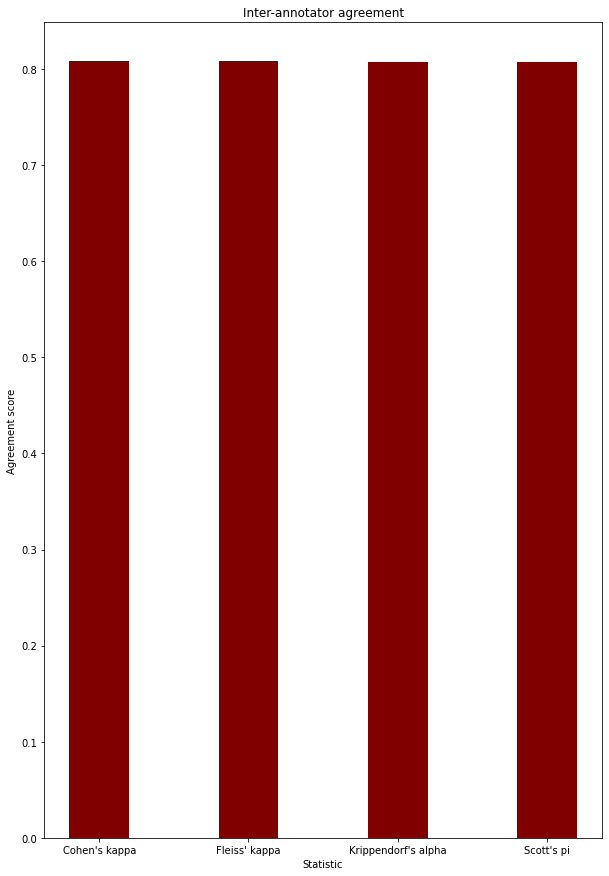

In [6]:
from nltk import agreement
import matplotlib.pyplot as plt

annotator_1 = train_df["polarity"].to_numpy()
annotator_2 = train_df["rating_polarity"].to_numpy()

taskdata=[[0,str(i),str(annotator_1[i])] for i in range(0,len(annotator_1))]+[[1,str(i),str(annotator_2[i])] for i in range(0,len(annotator_2))]
ratingtask = agreement.AnnotationTask(data=taskdata)

cohen_kappa = ratingtask.kappa()
fleiss_kappa = ratingtask.multi_kappa()
krippendorf_alpha = ratingtask.alpha()
scotts_pi = ratingtask.pi()

scores = {"Cohen's kappa": cohen_kappa, "Fleiss' kappa": fleiss_kappa, "Krippendorf's alpha": krippendorf_alpha, "Scott's pi" : scotts_pi}

statistic = list(scores.keys())
values = list(scores.values())

fig = plt.figure(figsize = (10, 15))
plt.bar(statistic, values, color ='maroon',
        width = 0.4)
plt.xlabel("Statistic")
plt.ylabel("Agreement score")
plt.title("Inter-annotator agreement")
plt.show()


In [7]:
print(values)

[0.808257993549457, 0.808257993549457, 0.8079026101629398, 0.8078990510242994]
